<a href="https://colab.research.google.com/github/SungwookLE/ImageRestore/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(f"os.getcwd(): {os.getcwd()}")

Mounted at /content/drive
os.getcwd(): /content


In [2]:
os.makedirs('data', exist_ok=True)
os.chdir('/content/data')
print(f"os.getcwd(): {os.getcwd()}")

os.getcwd(): /content/data


In [3]:
import zipfile

def extract_zip(zip_name):
    with zipfile.ZipFile(zip_name) as zip:
        zip.extractall()
        zip.close()

extract_zip('/content/drive/MyDrive/dacon_23/data/open.zip')

In [11]:
os.chdir('/content')

In [12]:
import random
import pandas as pd
import numpy as np
import cv2
import zipfile
import math
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models
from torchvision import transforms

import warnings

In [13]:
# paper: https://arxiv.org/abs/1501.00092
# https://dacon.io/competitions/official/236168/codeshare/8907?page=1&dtype=recent

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

In [15]:
CFG = {
    'IMG_SIZE':1024,  # 1024
    'EPOCHS':30,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4,
    'SEED':41
}

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG["SEED"]) # seed 고정

In [17]:
train_lr_paths = sorted(glob.glob("./data/train/lr/*.jpg"))
train_hr_paths = sorted(glob.glob("./data/train/hr/*.jpg"))
test_lr_paths = sorted(glob.glob("./data/test/lr/*.jpg"))

In [18]:
assert len(train_lr_paths) == len(train_hr_paths), "Somthing Wrong"
len(train_lr_paths), len(test_lr_paths)

(29603, 135)

TRAIN_10886.jpg


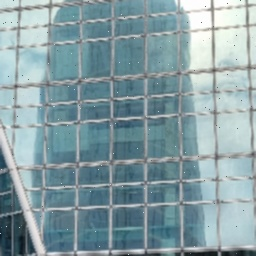

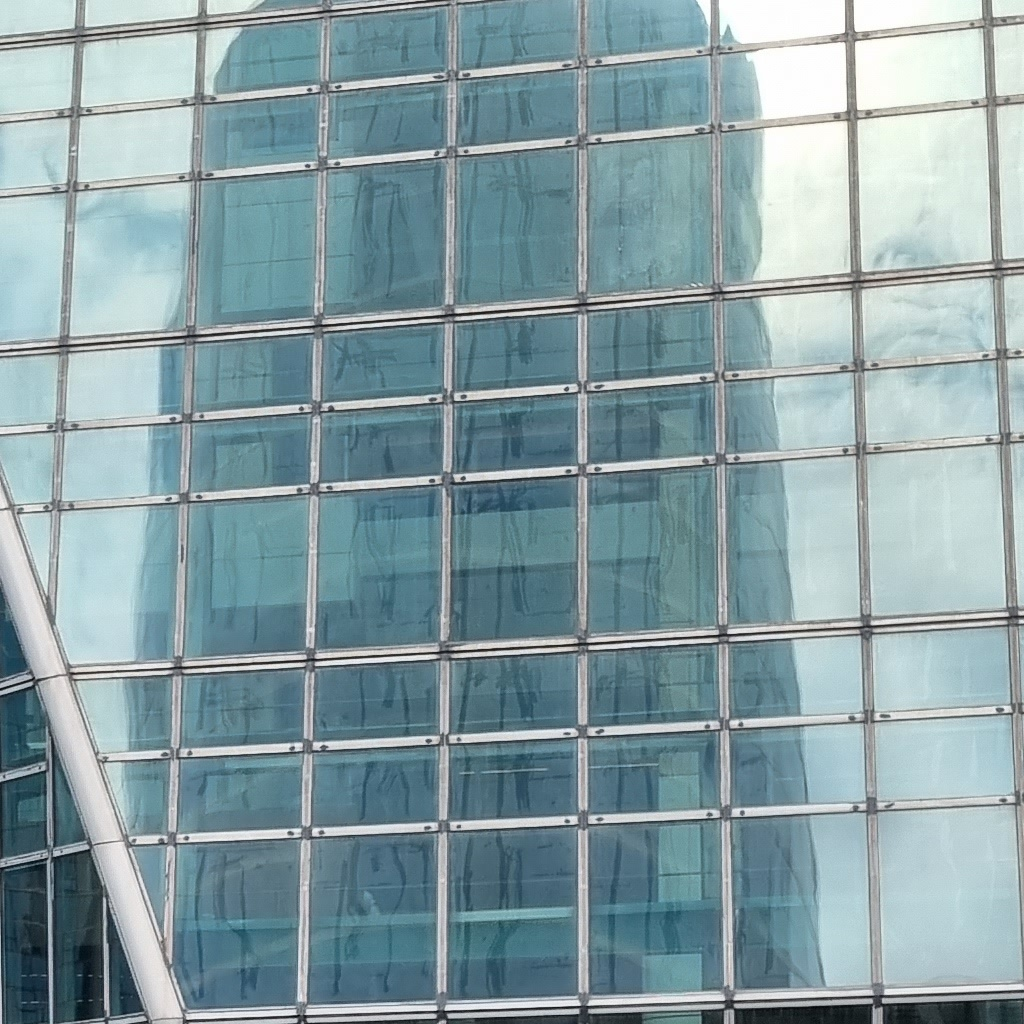

In [20]:
from google.colab.patches import cv2_imshow

def show_img():
    filepath = random.choice(train_lr_paths)
    filename_lr = filepath.split('/')[-1]
    filepath_hr = "./data/train/hr/" + filename_lr

    mat_lr = cv2.imread(filepath) # 256 256 3
    mat_hr = cv2.imread(filepath_hr) # 1024 1024 3
    print(filename_lr)
    cv2_imshow(mat_lr)
    cv2_imshow(mat_hr)

show_img()

In [21]:
class CustomDataset(Dataset):
    def __init__(self, lr_paths, hr_paths, transforms, train_mode):
        self.lr_paths = lr_paths
        self.hr_paths = hr_paths
        self.transforms = transforms
        self.train_mode = train_mode

    def __getitem__(self, index):
        lr_path = self.lr_paths[index]
        lr_img = cv2.imread(lr_path)
        lr_img = cv2.resize(lr_img, (CFG["IMG_SIZE"], CFG["IMG_SIZE"]), interpolation=cv2.INTER_CUBIC)

        if self.train_mode:
            hr_path = self.hr_paths[index]
            hr_img = cv2.imread(hr_path)
            hr_img = cv2.resize(hr_img, (CFG["IMG_SIZE"], CFG["IMG_SIZE"]), interpolation=cv2.INTER_CUBIC)
            if self.transforms is not None:
                transformed = self.transforms(image=lr_img, label=hr_img)
                lr_img = transformed['image'] / 255.
                hr_img = transformed['label'] / 255.
            return lr_img, hr_img

        else:
            file_name = lr_path.split('/')[-1]
            if self.transforms is not None:
                transformed = self.transforms(image=lr_img)
                lr_img = transformed['image'] / 255.

            return lr_img, file_name


    def __len__(self):
        return len(self.lr_paths)



In [22]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)],
        additional_targets={'image': 'image', 'label': 'image'}
    )

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)], # 이미지 (H x W x C) -> ternsor의 shape 으로 바꿔준것 (C x H x W)
        additional_targets={'image': 'image', 'label': 'image'}
    )

In [23]:
train_dataset = CustomDataset(train_lr_paths, train_hr_paths, get_train_transform(), True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

test_dataset = CustomDataset(test_lr_paths, None, get_test_transform(), False)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [24]:
class SRCNN(nn.Module):
    def __init__(self, num_channels = 3, feature_dim = 64, map_dim = 32):
        super(SRCNN, self).__init__()

        # Feature extraction layer.
        self.features = nn.Sequential(
            nn.Conv2d(num_channels, feature_dim, (9,9), (1,1), (4,4)),
            nn.ReLU()
        )

        # Non-linear mapping layer.
        self.map = nn.Sequential(
            nn.Conv2d(feature_dim, map_dim, (5,5), (1,1), (2,2)),
            nn.ReLU()
        )

        # Rebuild the layer.
        self.reconstruction = nn.Conv2d(map_dim, num_channels, (5,5), (1,1), (2,2))

        # Initialize model weights
        self._initialize_weights()

    def forward(self, x):
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)
        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initailized by random extraction 0.001 (deviation is 0)

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt( 2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

            nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
            nn.init.zeros_(self.reconstruction.bias.data)

In [25]:
def train(model, optimizer, train_loader, scheduler, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_model = None
    best_loss = 9999

    for epoch in range(1, CFG["EPOCHS"] + 1):
        model.train()
        train_loss = []
        for lr_img, hr_img in tqdm(iter(train_loader)):
            lr_img, hr_img = lr_img.float().to(device), hr_img.float().to(device)

            optimizer.zero_grad()

            pred_hr_img = model(lr_img)
            loss = criterion(pred_hr_img, hr_img)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        _train_loss = np.mean(train_loss)
        print(f"Epoch: [{epoch}] Train Loss: [{_train_loss:.5f}]")

        if best_loss > _train_loss:
            best_loss = _train_loss
            best_model = model

    return best_model




In [26]:
model = SRCNN()
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

infer_model = train(model, optimizer, train_loader, scheduler, device)

  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [1] Train Loss: [0.01007]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [2] Train Loss: [0.00915]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [3] Train Loss: [0.00901]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [4] Train Loss: [0.00893]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [5] Train Loss: [0.00887]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [6] Train Loss: [0.00877]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [7] Train Loss: [0.00875]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [8] Train Loss: [0.00873]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [9] Train Loss: [0.00872]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [10] Train Loss: [0.00871]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [11] Train Loss: [0.00866]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [12] Train Loss: [0.00865]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [13] Train Loss: [0.00865]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [14] Train Loss: [0.00864]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [15] Train Loss: [0.00864]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [16] Train Loss: [0.00861]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [17] Train Loss: [0.00861]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [18] Train Loss: [0.00861]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [19] Train Loss: [0.00861]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [20] Train Loss: [0.00860]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [21] Train Loss: [0.00859]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [22] Train Loss: [0.00859]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [23] Train Loss: [0.00859]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [24] Train Loss: [0.00859]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [25] Train Loss: [0.00859]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [26] Train Loss: [0.00858]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [27] Train Loss: [0.00858]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [28] Train Loss: [0.00858]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [29] Train Loss: [0.00858]


  0%|          | 0/7401 [00:00<?, ?it/s]

Epoch: [30] Train Loss: [0.00858]


In [27]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    pred_img_list = []
    name_list = []

    with torch.no_grad():
        for lr_img, file_name in tqdm(iter(test_loader)):
            lr_img = lr_img.float().to(device)

            pred_hr_img = model(lr_img)

            for pred, name in zip(pred_hr_img, file_name):
                pred = pred.cpu().clone().detach().numpy()
                pred = pred.transpose(1,2,0)
                pred = pred * 255

                pred_img_list.append(pred.astype('uint8'))
                name_list.append(name)

    return pred_img_list, name_list

In [28]:
pred_img_list, pred_name_list = inference(infer_model, test_loader, device)

  0%|          | 0/34 [00:00<?, ?it/s]

In [29]:
os.makedirs('./submission', exist_ok=True)
os.chdir("./submission/")
sub_imgs = []
for path, pred_img in tqdm(zip(pred_name_list, pred_img_list)):
    cv2.imwrite(path, pred_img)
    sub_imgs.append(path)
submission = zipfile.ZipFile("../submission.zip", 'w')
for path in sub_imgs:
    submission.write(path)
submission.close()
print('Done.')

0it [00:00, ?it/s]

Done.


In [30]:
from google.colab import files
files.download('../submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>